# Importing Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

import lightgbm as lgb

!pip install catboost
from catboost import CatBoostClassifier, Pool, metrics, cv, CatBoostRegressor

!pip install boruta
from boruta import BorutaPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 2.1 MB/s eta 0:00:00


In [3]:
pd.set_option('display.max_columns', None)

# Preprocessing

In [4]:
df =  pd.read_csv('/content/drive/MyDrive/Interview Material/Dataiku/Take home assignment/Dataiku Data Scientist Technical Assessment/census_income_learn.csv', header=None)
df_test =  pd.read_csv('/content/drive/MyDrive/Interview Material/Dataiku/Take home assignment/Dataiku Data Scientist Technical Assessment/census_income_test.csv', header=None)

In [5]:
df.shape, df_test.shape

((199523, 42), (99762, 42))

In [6]:
def add_column_names(df):
    """
    Adds column names to the given dataframe and returns the updated one.

    """

    columns = [
        'age',
        'class_of_work',
        'industry_code',
        'occupation_code',
        'education',
        'wage_per_hour',
        'enrolled_in_edu_inst_last_wk',
        'marital_status',
        'major_industry_code',
        'major_occupation_code',
        'race',
        'hispanic_origin',
        'sex',
        'member_of_labor_union',
        'reason_for_unemployment',
        'full_or_part_time_employment_stat',
        'capital_gains',
        'capital_losses',
        'dividends_from_stocks',
        'tax_filer_status',
        'region_of_previous_residence',
        'state_of_previous_residence',
        'detailed_household_and_family_stat',
        'detailed_household_summary_in_household',
        'instance_weight',
        'migration_code_change_in_msa',
        'migration_code_change_in_reg',
        'migration_code_move_within_reg',
        'live_in_this_house_1_year_ago',
        'migration_prev_res_in_sunbelt',
        'num_persons_worked_for_employer',
        'family_member_under_18',
        'country_of_birth_father',
        'country_of_birth_mother',
        'country_of_birth_self',
        'citizenship',
        'own_business_or_self_employed',
        'fill_inc_questionnaire_for_veterans_admin',
        'veteran_benefits',
        'weeks_worked_in_years',
        'year',
        'target'
    ]

    df.rename(columns=dict(enumerate(columns)), inplace=True)
        
    return df

def preprocess(df):
    """
    Performs basic preprocessing on the given dataframe and returns the updated one.

    """

    #Setting column names and dropping duplicates
    df = add_column_names(df).drop_duplicates()

    # Drops the instance weight column
    df.drop(columns='instance_weight', axis=1, inplace=True)

    #Setting target
    mapping_dict = {' - 50000.':0, ' 50000+.':1}
    df['target'] = df['target'].map(mapping_dict)

    return df

In [7]:
df = preprocess(df)
df_test = preprocess(df_test)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-6-39d84280ba7b>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].map(mapping_dict)


# EDA & Feature Engineering

In [8]:
df.head()

,age,class_of_work,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_status,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_member_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veteran_benefits,weeks_worked_in_years,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


In [9]:
df.dtypes

age                                           int64
class_of_work                                object
industry_code                                 int64
occupation_code                               int64
education                                    object
wage_per_hour                                 int64
enrolled_in_edu_inst_last_wk                 object
marital_status                               object
major_industry_code                          object
major_occupation_code                        object
race                                         object
hispanic_origin                              object
sex                                          object
member_of_labor_union                        object
reason_for_unemployment                      object
full_or_part_time_employment_stat            object
capital_gains                                 int64
capital_losses                                int64
dividends_from_stocks                         int64
tax_filer_st

In [10]:
df.shape, df_test.shape

((196294, 41), (98879, 41))

Text(0.5, 1.0, 'Distribution of target')

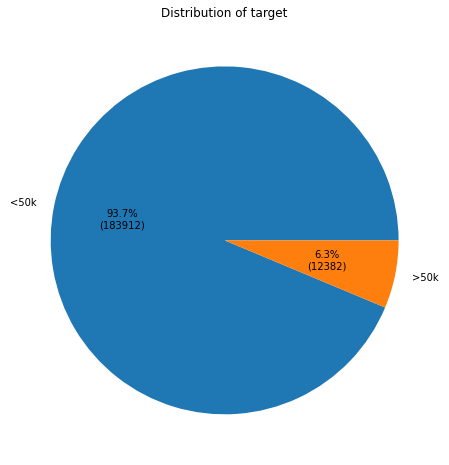

In [11]:
#Find distribution of target

def autopct_format(values):
    def format_pct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{:.1f}%\n({:d})'.format(pct, val)
    return format_pct

counts = df['target'].value_counts()
labels = ['<50k', '>50k']

fig = plt.figure(figsize=(8,8))
plt.pie(counts, labels = labels, autopct=autopct_format(counts))
plt.title("Distribution of target")

In [12]:
# Get the count of empty and NaN values in each column
null_counts = df.isnull().sum()
print(null_counts)

age                                          0
class_of_work                                0
industry_code                                0
occupation_code                              0
education                                    0
wage_per_hour                                0
enrolled_in_edu_inst_last_wk                 0
marital_status                               0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_labor_union                        0
reason_for_unemployment                      0
full_or_part_time_employment_stat            0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_status                             0
region_of_previous_residence                 0
state_of_prev

## Continuous columns

In [13]:
#Adding new features based on continuous columns

def add_features(df):

    df['estimated_income_wage'] = df['wage_per_hour']*df['weeks_worked_in_years']
    df['estimated_capital_stock_profit'] = df['capital_gains'] - df['capital_losses'] + df['dividends_from_stocks']
    df['estimated_income'] = df['estimated_income_wage'] + df['estimated_capital_stock_profit']

    df['estimated_income_wage'].astype(int)
    df['estimated_capital_stock_profit'].astype(int)
    df['estimated_income'].astype(int)

    return df

In [14]:
df = add_features(df)
df_test = add_features(df_test)

In [15]:
continuous_cols = ['age','wage_per_hour','capital_gains','capital_losses',
                      'dividends_from_stocks','num_persons_worked_for_employer',
                      'weeks_worked_in_years','estimated_income_wage','estimated_capital_stock_profit','estimated_income']

In [16]:
df[continuous_cols].describe()

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_years,estimated_income_wage,estimated_capital_stock_profit,estimated_income
count,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000
mean,34.929468,56.336505,441.870037,37.927593,200.722386,1.988105,23.553889,2640.395213,604.664829,3245.060043
std,22.210001,277.054333,4735.677027,274.081174,2000.130616,2.371018,24.428588,13540.817662,5383.111555,14556.753312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4608.000000,-4608.000000
25%,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,4.000000,52.000000,0.000000,0.000000,0.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,52.000000,519948.000000,199998.000000,519948.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


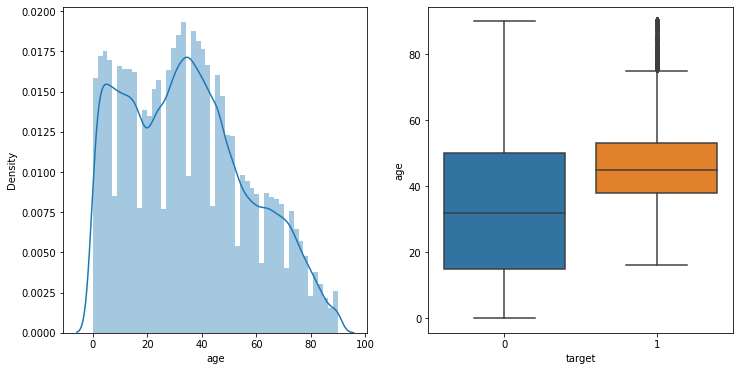

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


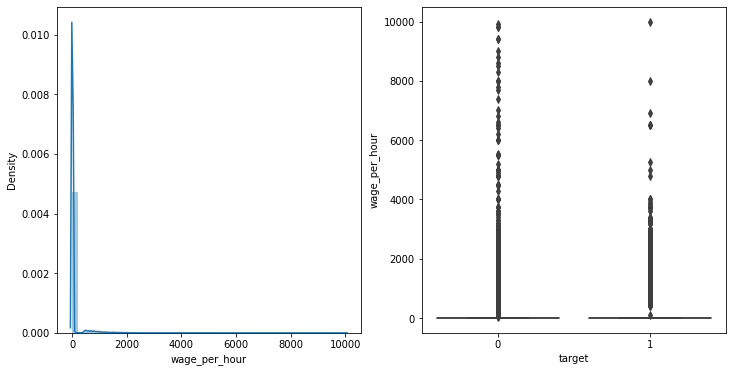

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


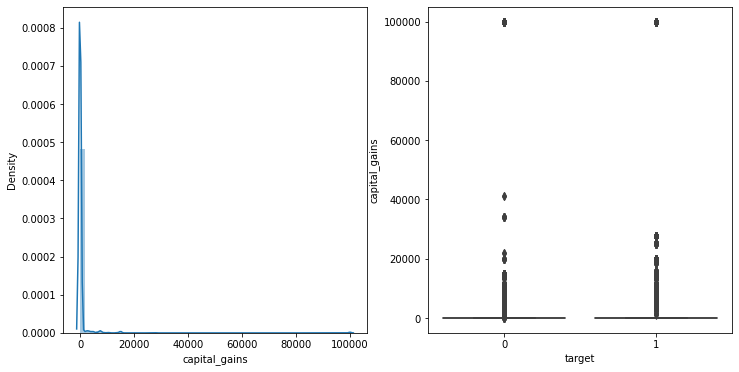

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


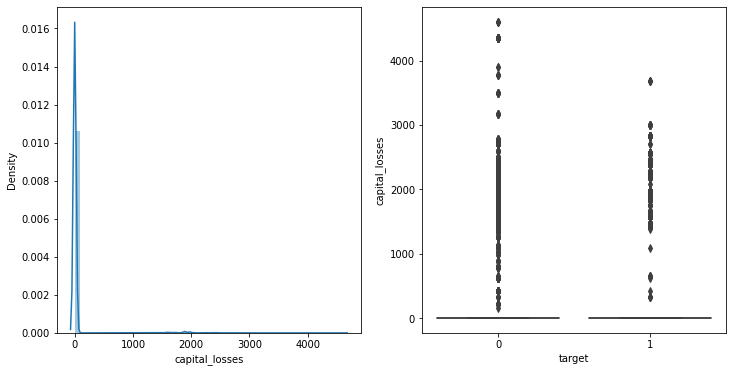

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


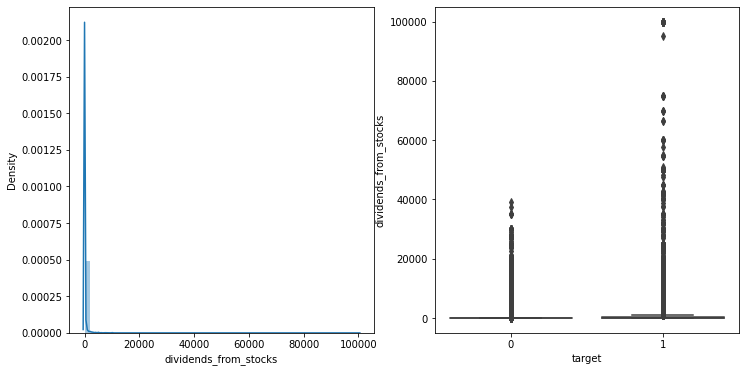

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


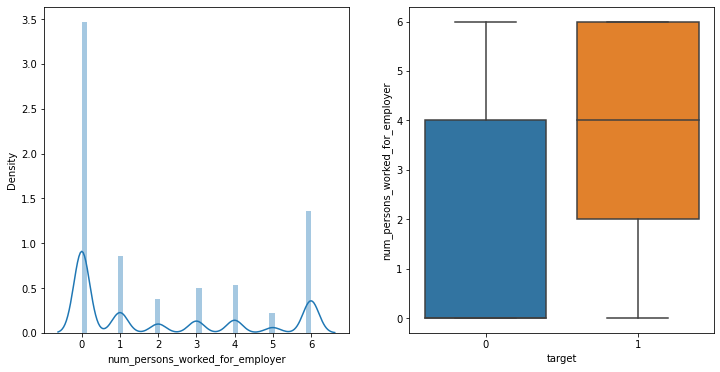

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


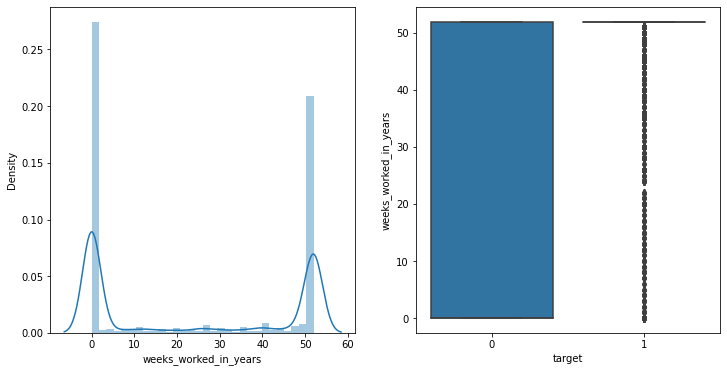

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


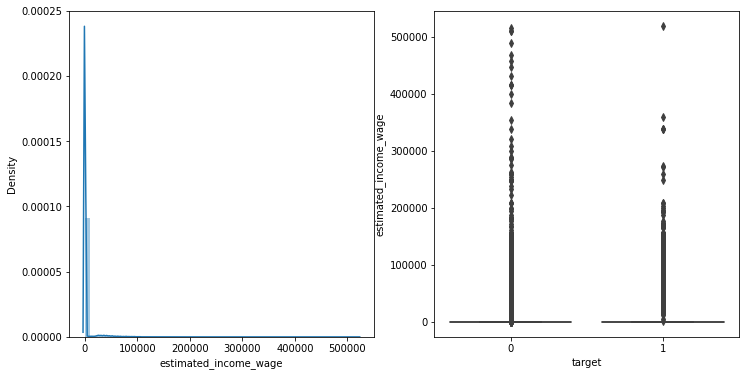

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


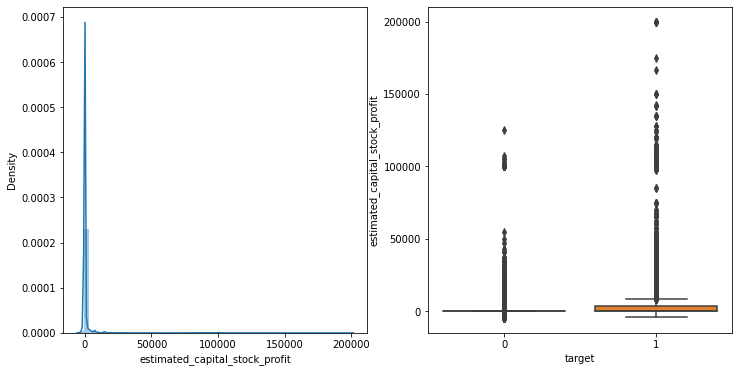

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


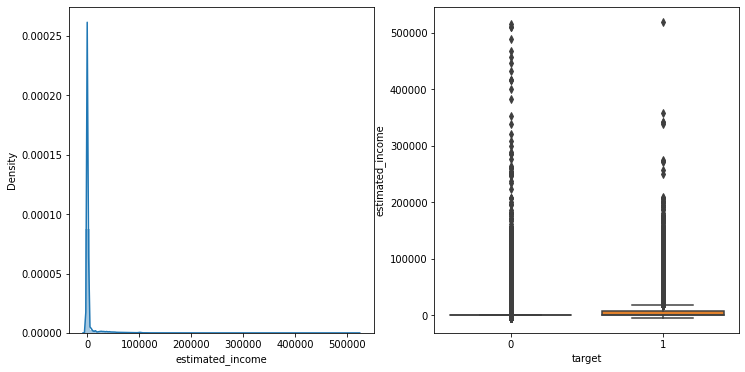

In [17]:
# Distribution of continuous columns and range for classes
for col in continuous_cols:

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.distplot(df[col], ax=axs[0])
    sns.boxplot(x='target', y=col, data=df, ax=axs[1])
    #sns.stripplot(x='target', y=col, data=df, ax=axs[2])
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


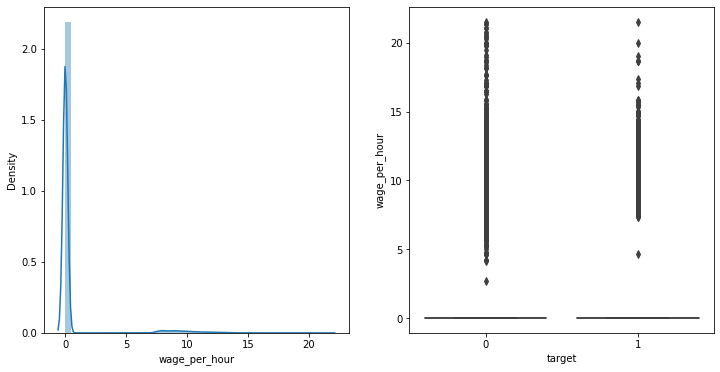

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


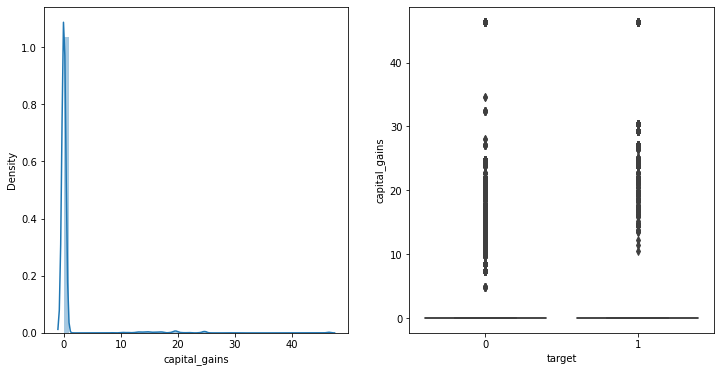

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


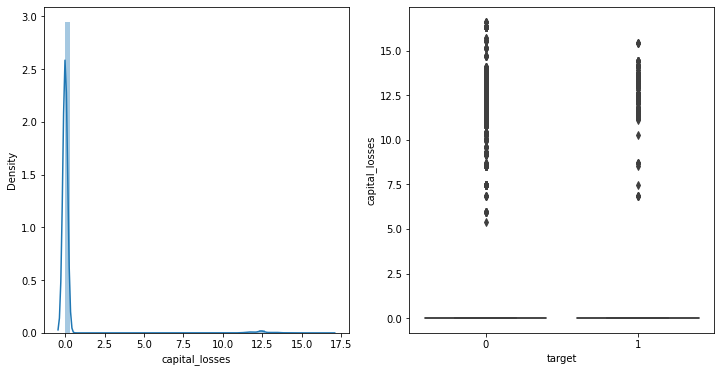

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


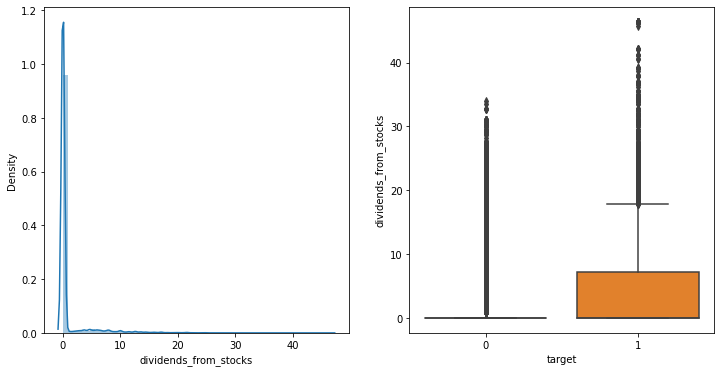

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


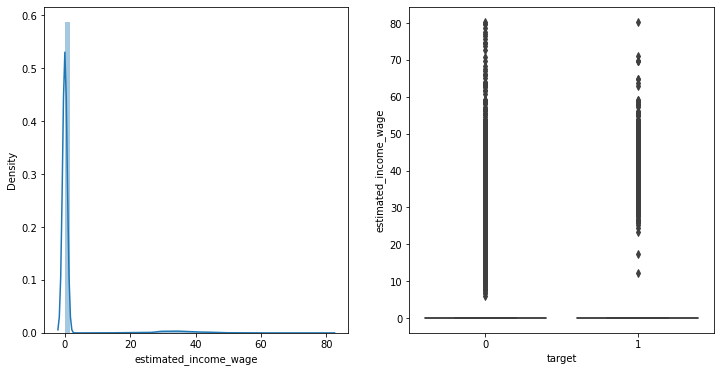

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


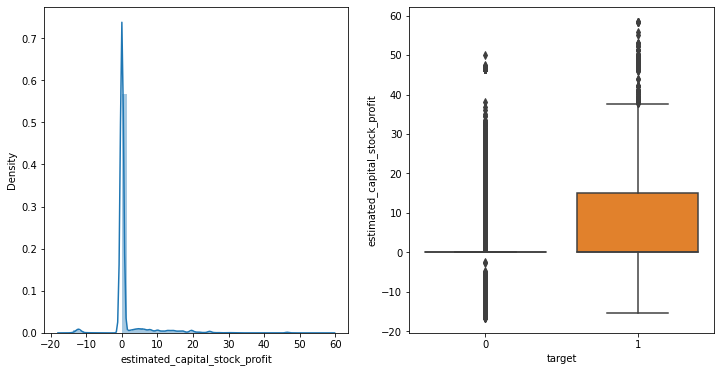

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


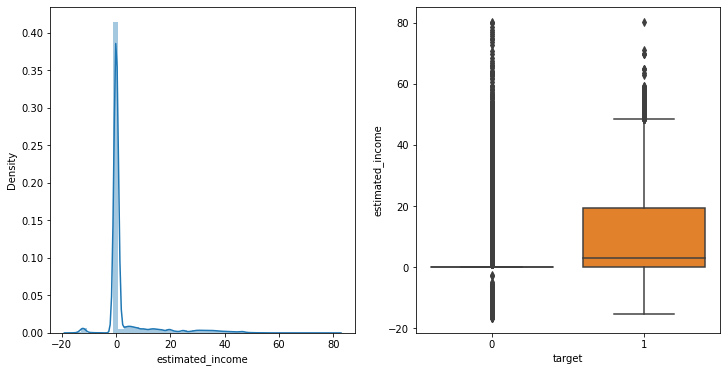

In [19]:
# Feature transformation of highly skewed continuous features by taking their cube root

for col in continuous_cols:
    if not col in ['age','num_persons_worked_for_employer','weeks_worked_in_years']:

        df[col] = np.cbrt(df[col])
        df_test[col] = np.cbrt(df_test[col])

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        sns.distplot(df[col], ax=axs[0])
        sns.boxplot(x='target', y=col, data=df, ax=axs[1])
        plt.show()

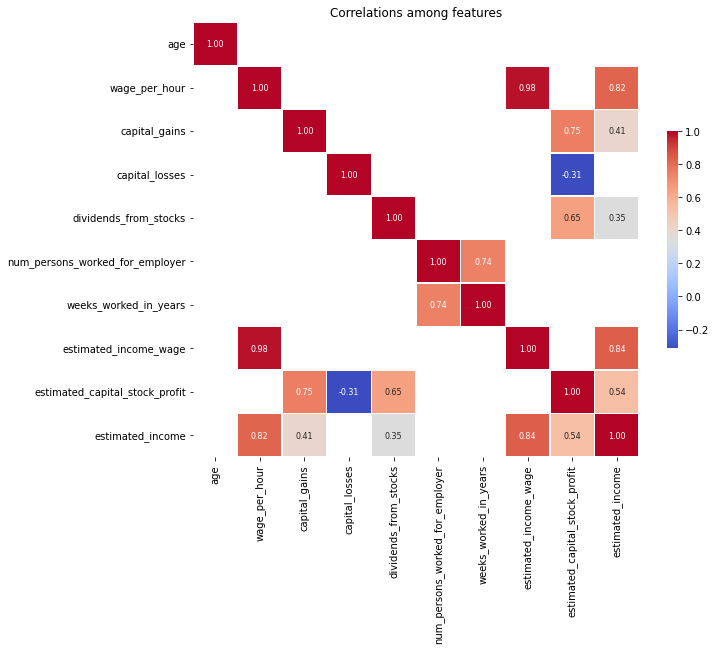

In [20]:
# Explore the correlation between all continuous features
corr = df[continuous_cols].corr()

# Keep only correlation higher than a threshold
threshold = 0.3
corr_threshold = corr[(corr > threshold) | (corr < -threshold)]

#Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_threshold, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'shrink': .5},annot_kws={'size': 8})
plt.title("Correlations among features")
plt.show()

target                             1.000000
estimated_capital_stock_profit     0.295875
capital_gains                      0.282905
dividends_from_stocks              0.279240
weeks_worked_in_years              0.260398
num_persons_worked_for_employer    0.220579
estimated_income                   0.163340
capital_losses                     0.142713
age                                0.132443
estimated_income_wage              0.001177
wage_per_hour                     -0.002429
Name: target, dtype: float64


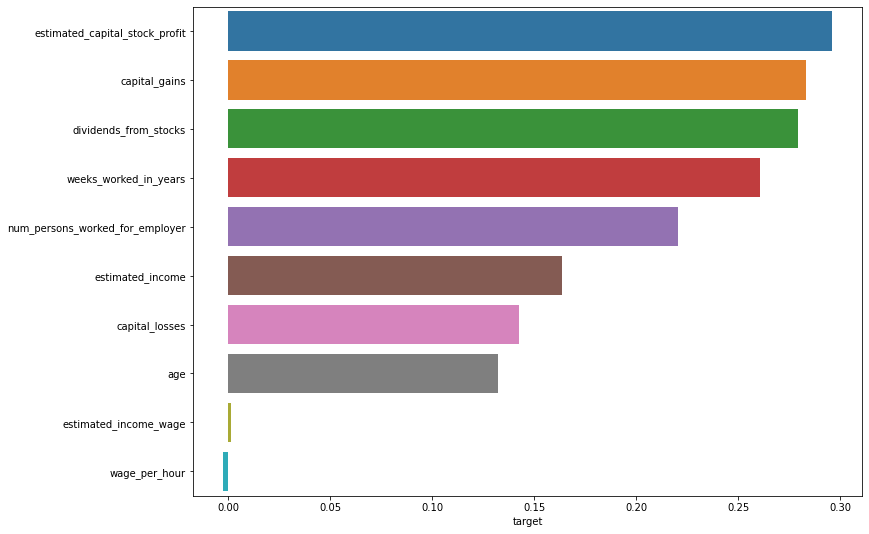

In [21]:
# Correlation with target
cm = df[continuous_cols+['target']].corr()['target'].sort_values(ascending=False)

plt.figure(figsize = (12,9))
sns.barplot(y = cm.index[1:], x = cm[1:])

print(cm.head(20))

In [22]:
# Dropping estimated_income_wage as it does not add significant value
# As it is highly correlated to wage_hour and has low correlation with target
drop_col = 'estimated_income_wage'
continuous_cols.remove(drop_col)
df.drop(drop_col, axis=1, inplace=True)
df_test.drop(drop_col, axis=1, inplace=True)

## Categorical columns

In [23]:
categorical_cols = list(set(df.columns) - set(continuous_cols)-set(['target']))
df[categorical_cols] = df[categorical_cols].astype('object')

In [24]:
df[categorical_cols].describe(include='object')

,year,enrolled_in_edu_inst_last_wk,reason_for_unemployment,tax_filer_status,race,country_of_birth_father,marital_status,veteran_benefits,live_in_this_house_1_year_ago,occupation_code,fill_inc_questionnaire_for_veterans_admin,migration_code_change_in_msa,country_of_birth_self,member_of_labor_union,state_of_previous_residence,region_of_previous_residence,detailed_household_and_family_stat,sex,full_or_part_time_employment_stat,migration_code_change_in_reg,family_member_under_18,hispanic_origin,migration_prev_res_in_sunbelt,citizenship,major_industry_code,own_business_or_self_employed,industry_code,major_occupation_code,migration_code_move_within_reg,detailed_household_summary_in_household,class_of_work,education,country_of_birth_mother
count,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294,196294
unique,2,3,6,6,5,43,7,3,3,47,3,10,43,3,51,6,38,2,8,9,5,10,4,5,24,3,52,15,10,8,9,17,43
top,94,Not in universe,Not in universe,Nonfiler,White,United-States,Married-civilian spouse present,2,Not in universe under 1 year old,0,Not in universe,?,United-States,Not in universe,Not in universe,Not in universe,Householder,Female,Children or Armed Forces,?,Not in universe,All other,?,Native- Born in the United States,Not in universe or children,0,0,Not in universe,?,Householder,Not in universe,High school graduate,United-States
freq,98279,183762,190226,71903,164380,156037,84194,149976,99434,97467,194310,98015,173783,177232,180562,180562,53242,102400,120632,98015,144161,168803,98015,173786,97467,177445,97467,97467,98015,75461,97029,48374,157355


In [25]:
#Observing value counts
for col in categorical_cols:
    print(col)
    print(df[col].value_counts())
    print()

year
94    98279
95    98015
Name: year, dtype: int64

enrolled_in_edu_inst_last_wk
 Not in universe          183762
 High school                6853
 College or university      5679
Name: enrolled_in_edu_inst_last_wk, dtype: int64

reason_for_unemployment
 Not in universe          190226
 Other job loser            2038
 Re-entrant                 2018
 Job loser - on layoff       976
 Job leaver                  598
 New entrant                 438
Name: reason_for_unemployment, dtype: int64

tax_filer_status
 Nonfiler                        71903
 Joint both under 65             67367
 Single                          37409
 Joint both 65+                   8326
 Head of household                7425
 Joint one under 65 & one 65+     3864
Name: tax_filer_status, dtype: int64

race
 White                          164380
 Black                           20206
 Asian or Pacific Islander        5821
 Other                            3645
 Amer Indian Aleut or Eskimo      2242
Name: race,

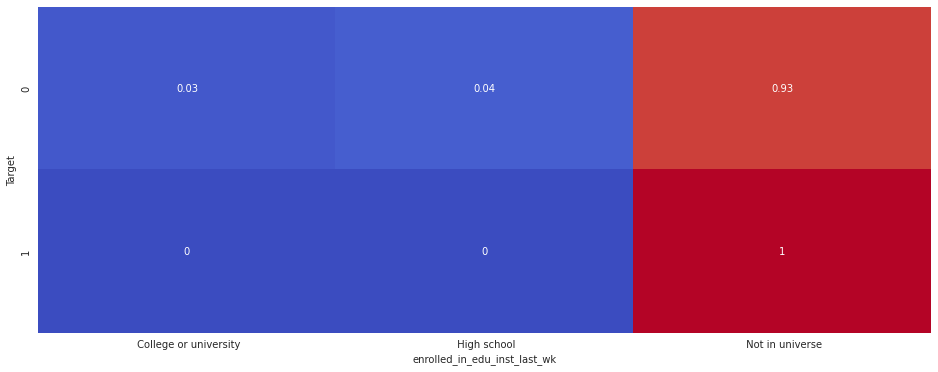

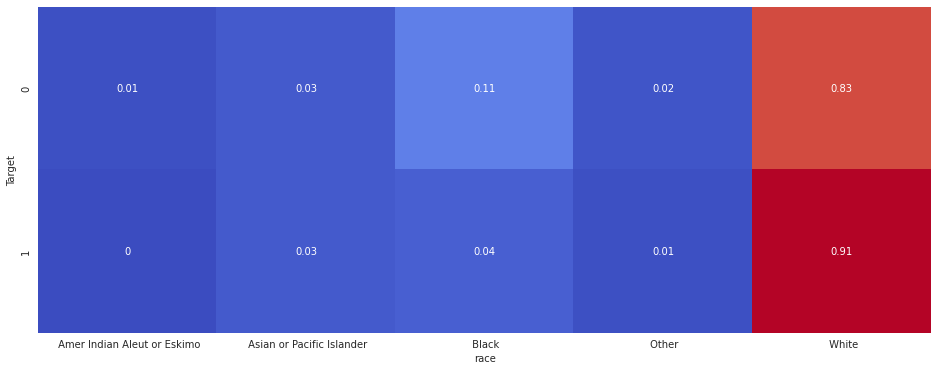

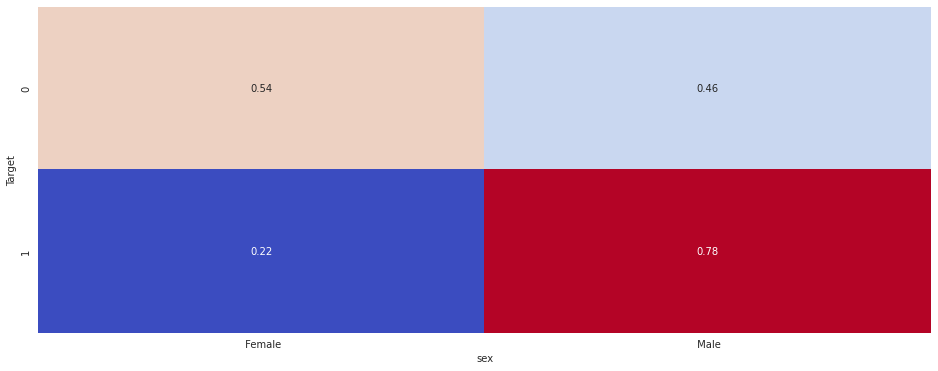

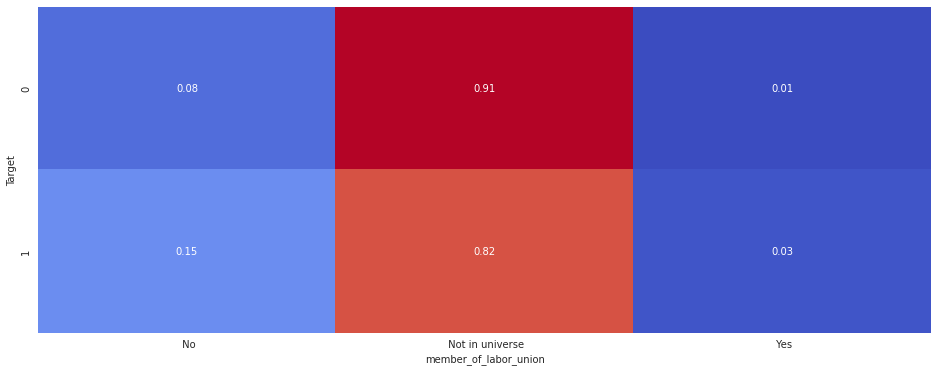

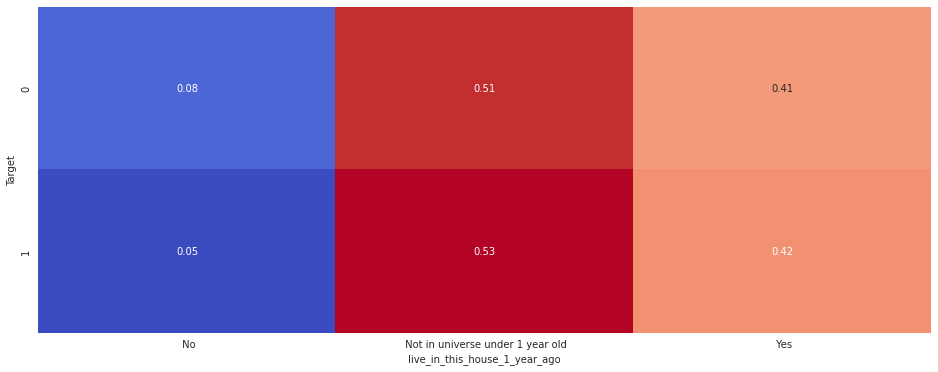

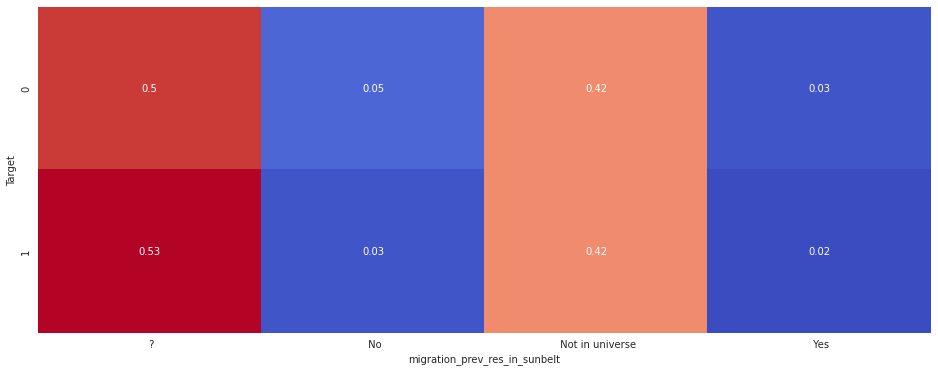

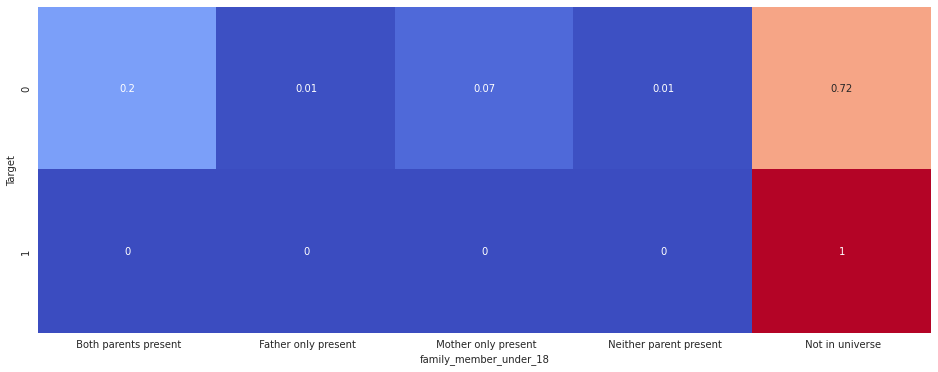

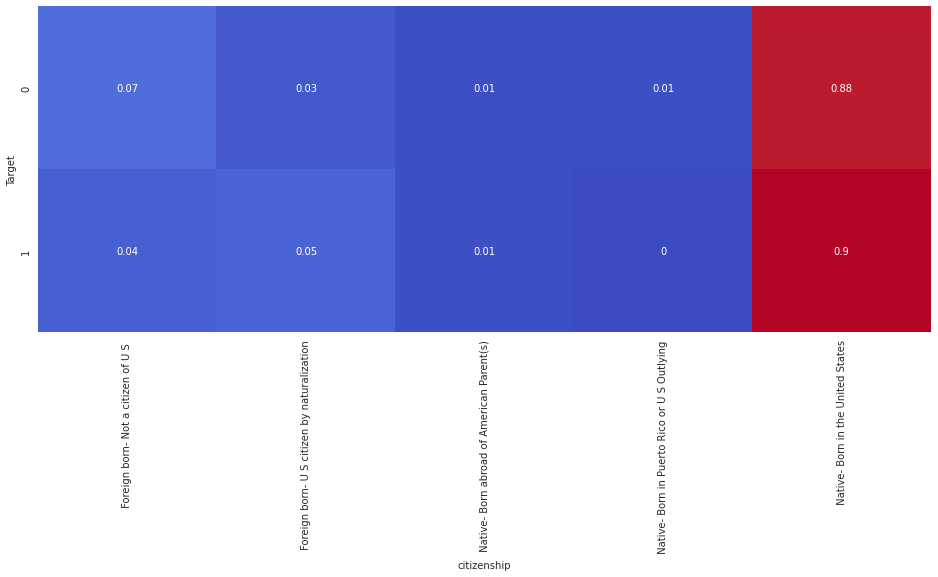

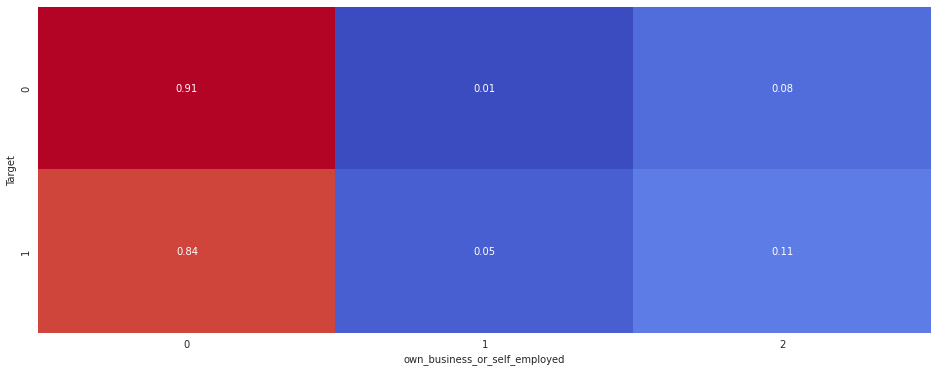

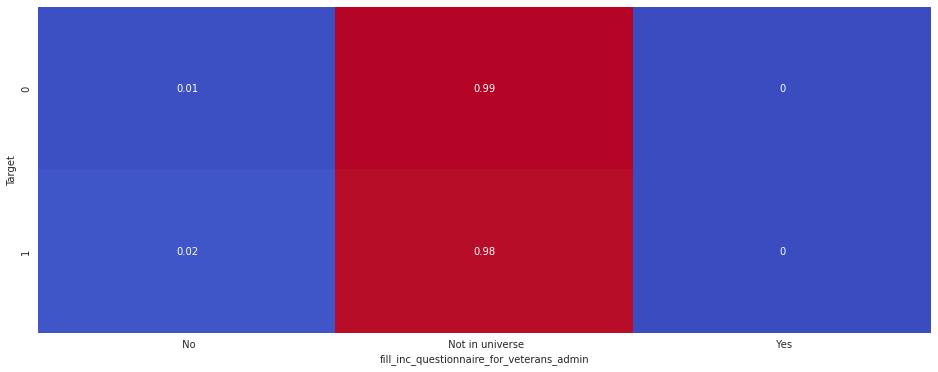

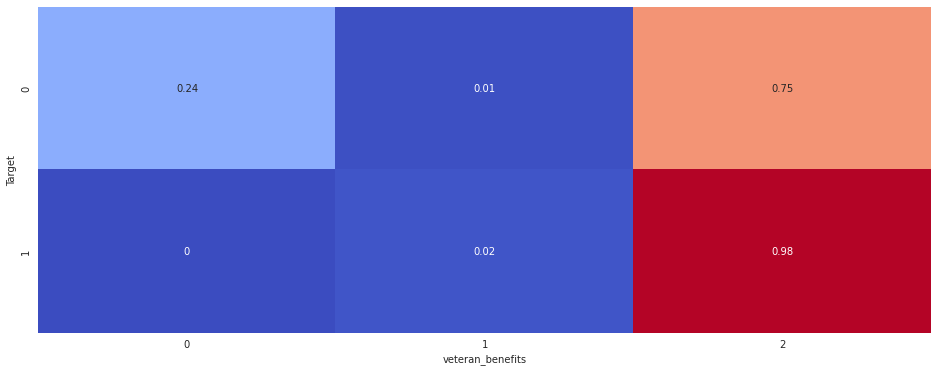

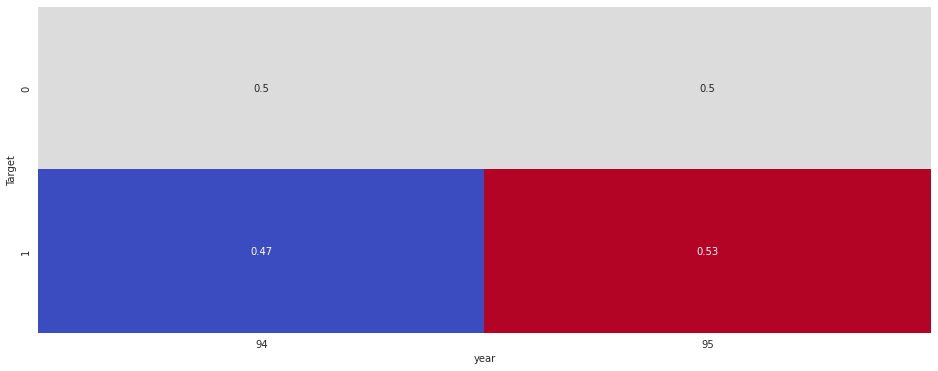

In [34]:
#frequency by which a features appear against target in percentage, for features with less than 6 unique values
for col in df.select_dtypes(include='object'):
    if df[col].nunique()<=5:
        cross_tab = pd.crosstab(df['target'], df[col], normalize='index')
        sns.set_style("whitegrid")

        plt.figure(figsize=(16, 6))
        sns.heatmap(round(cross_tab,2), annot=True, cmap='coolwarm', fmt='g', cbar=False)
        plt.xlabel(col)
        plt.ylabel("Target")
        plt.show()

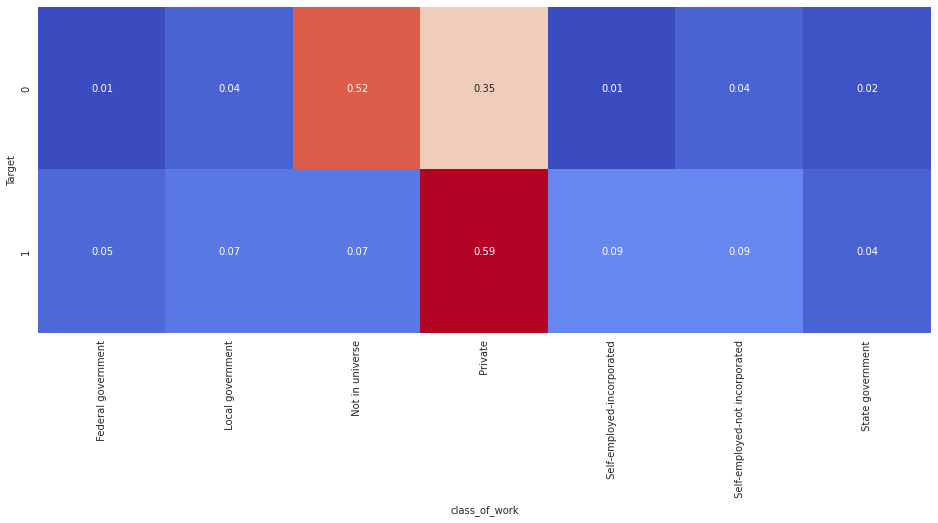

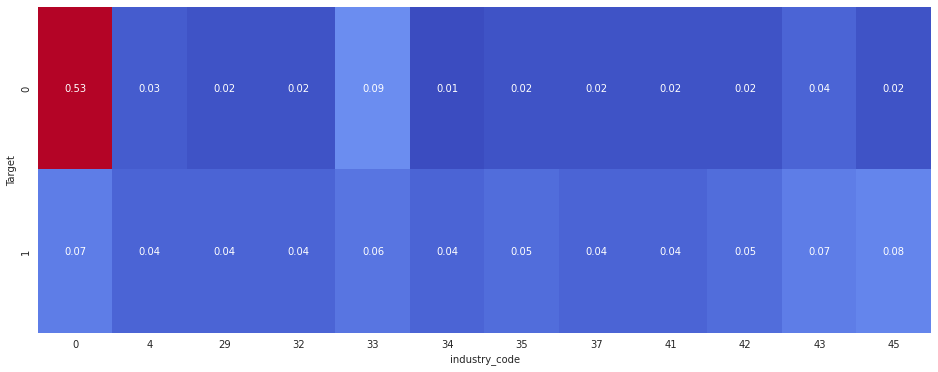

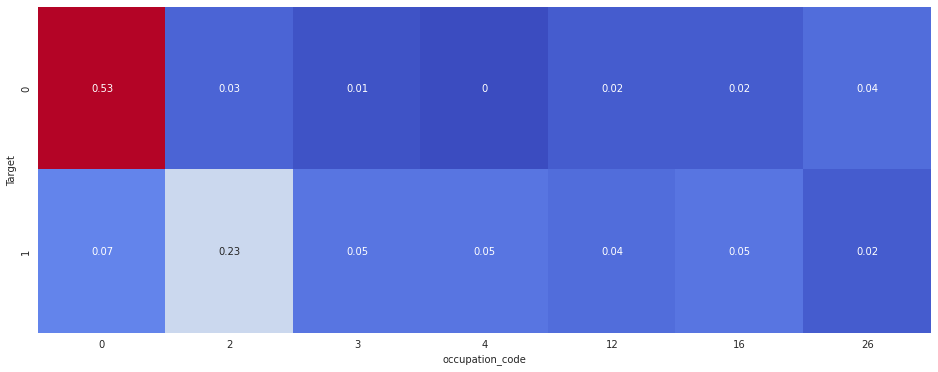

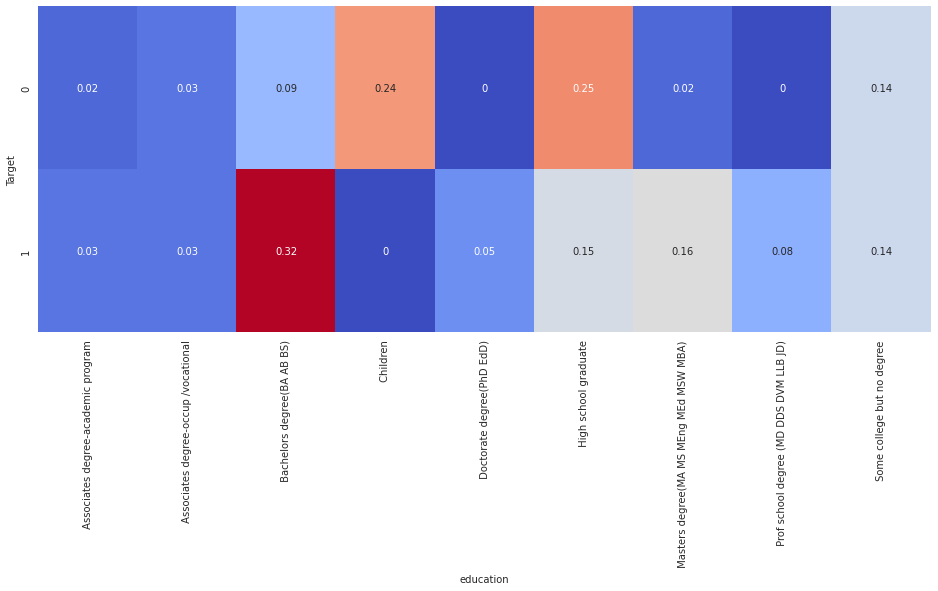

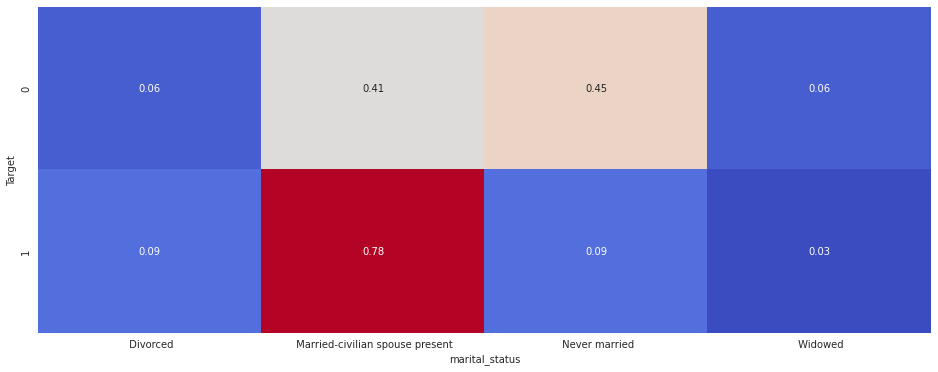

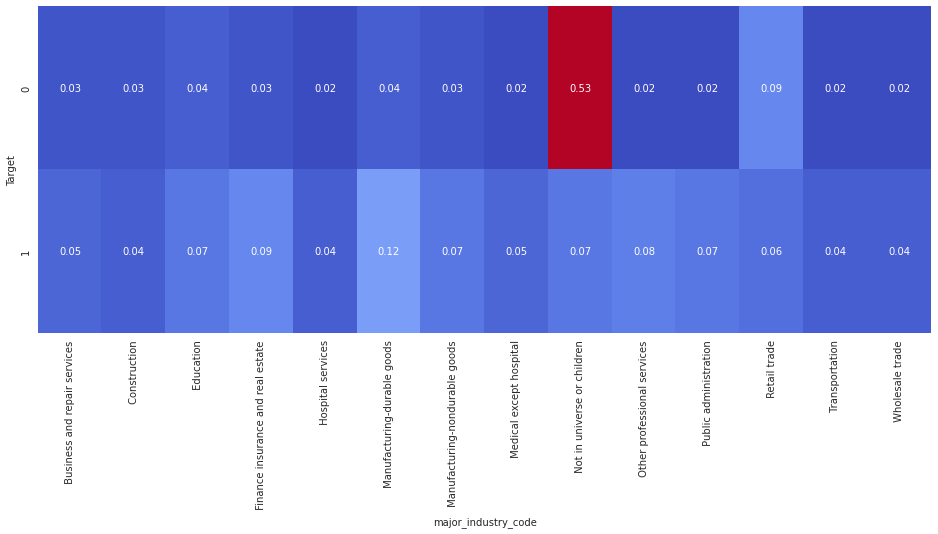

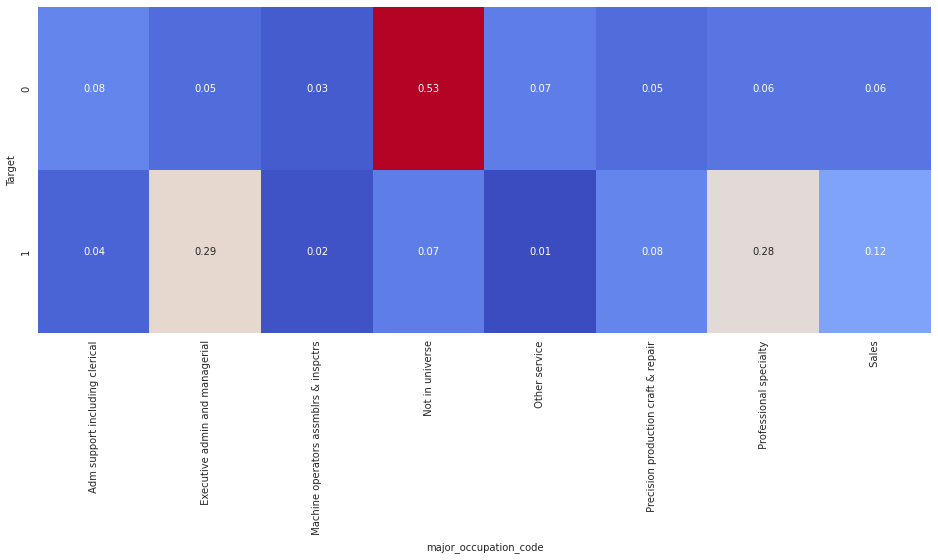

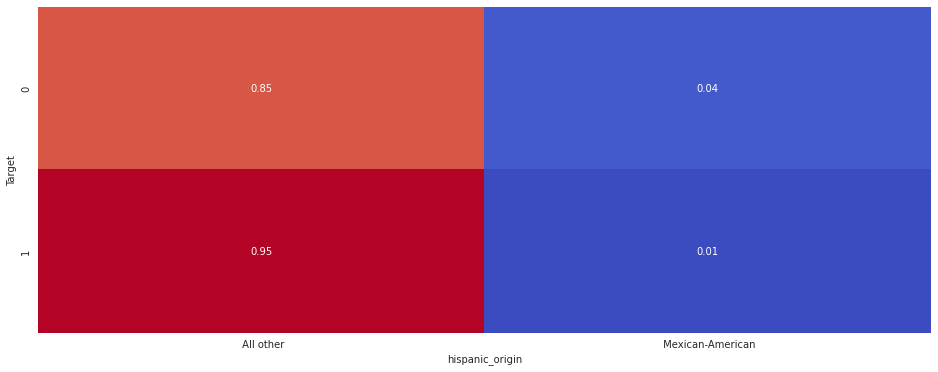

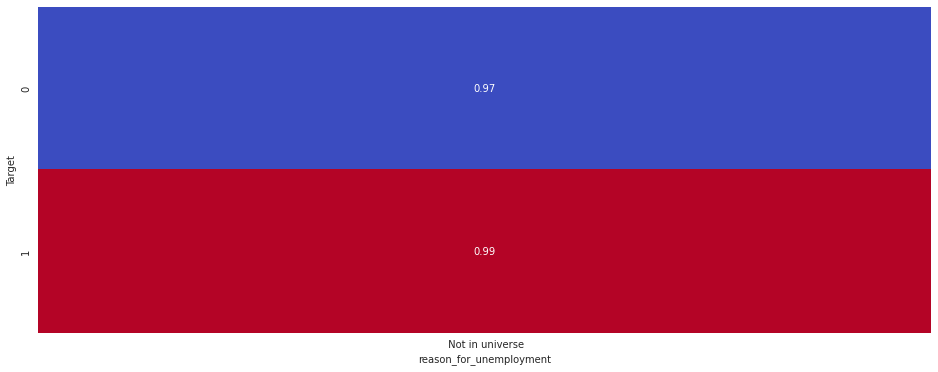

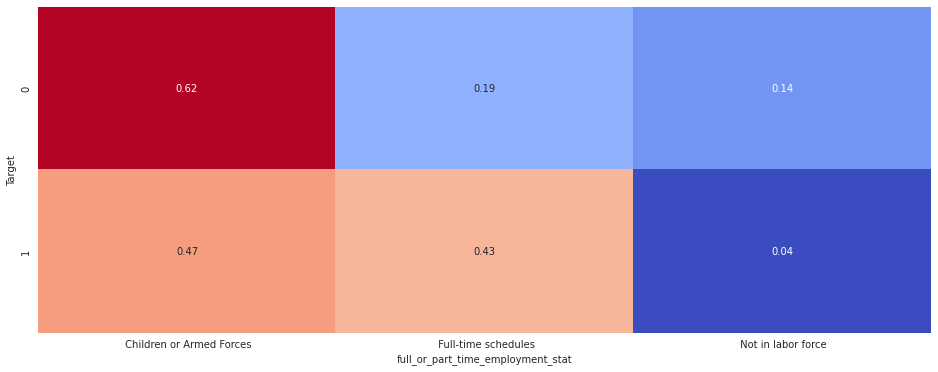

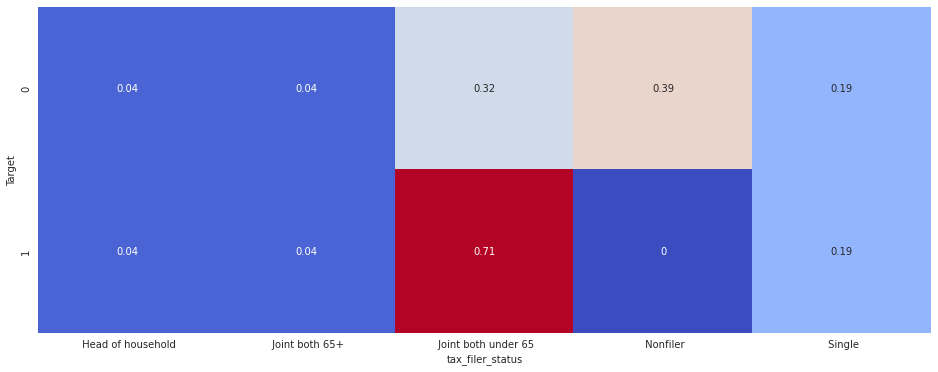

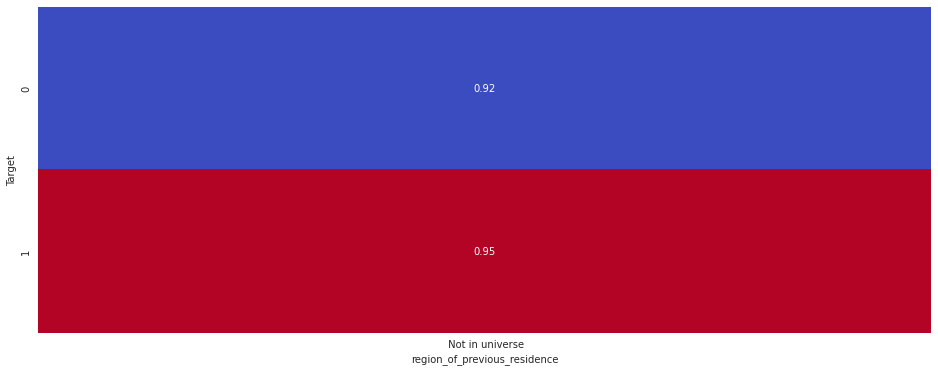

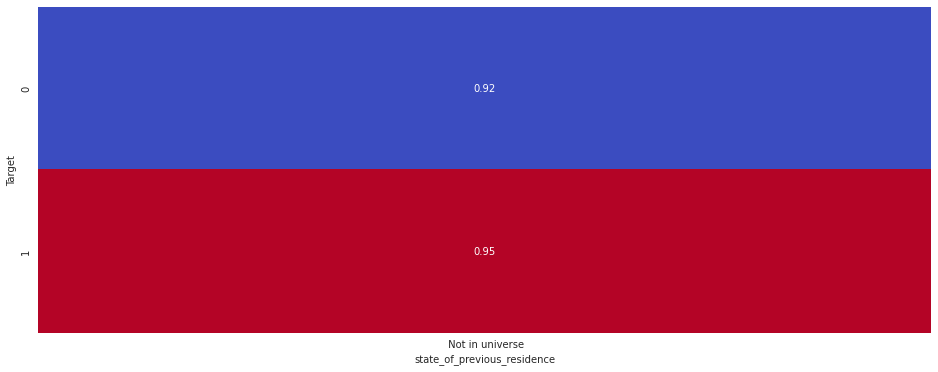

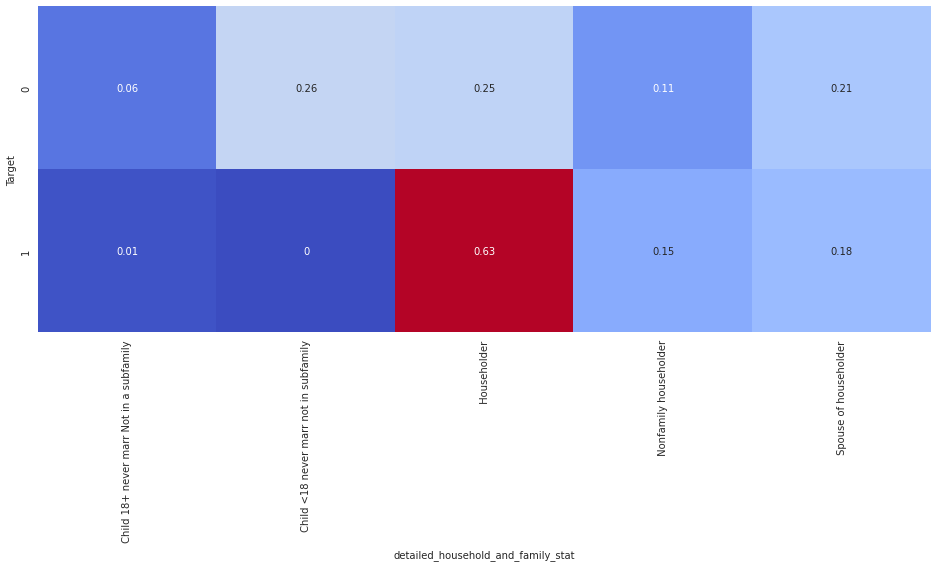

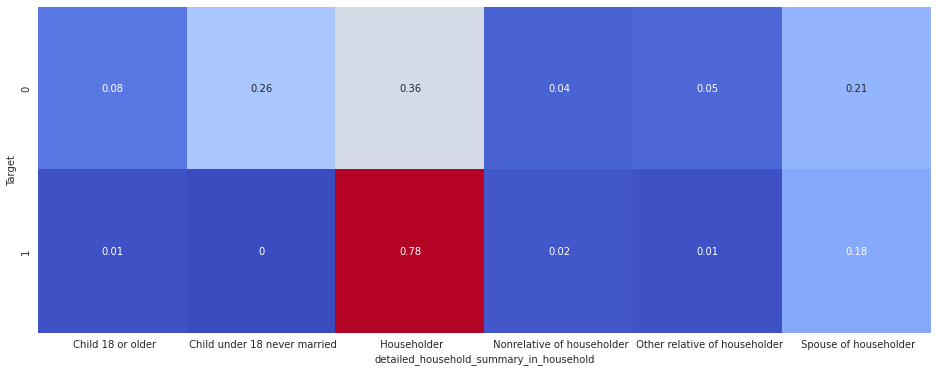

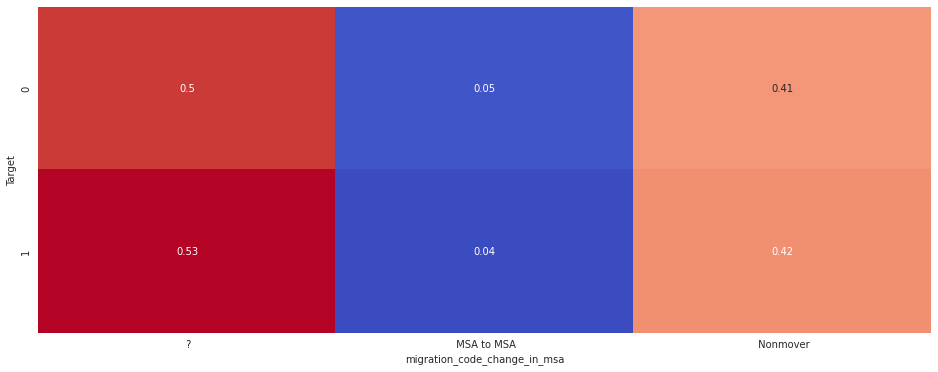

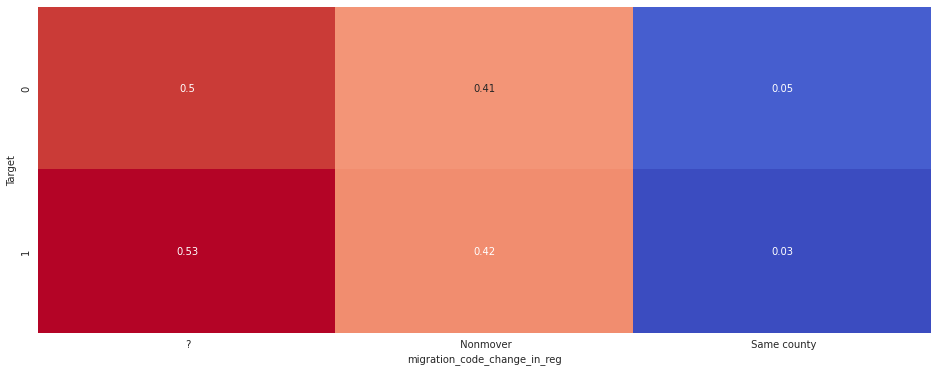

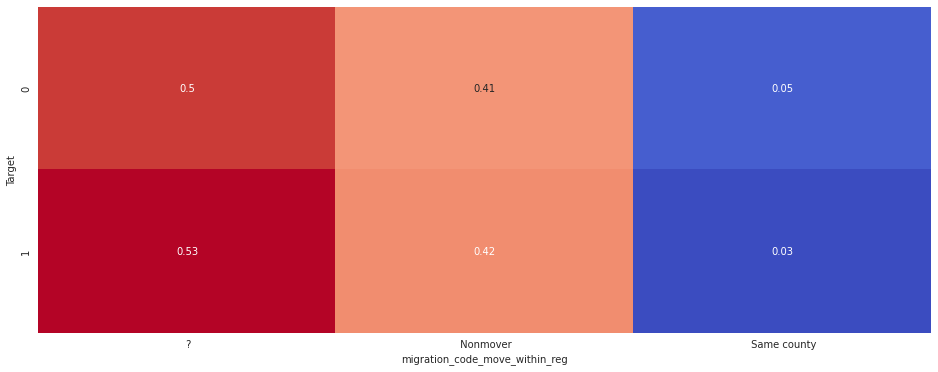

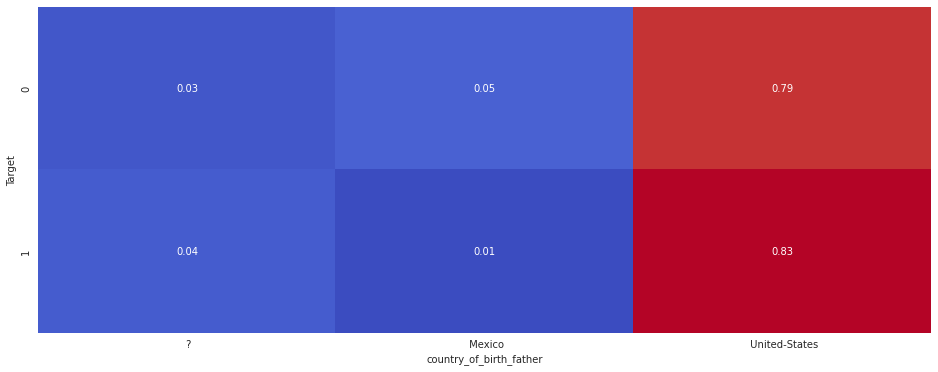

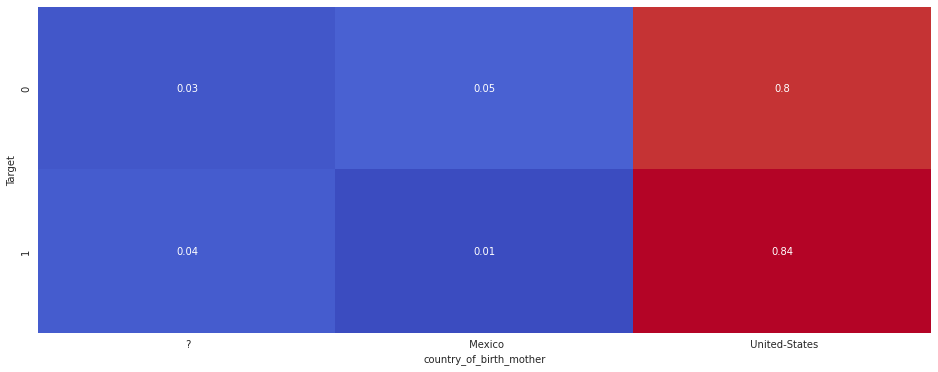

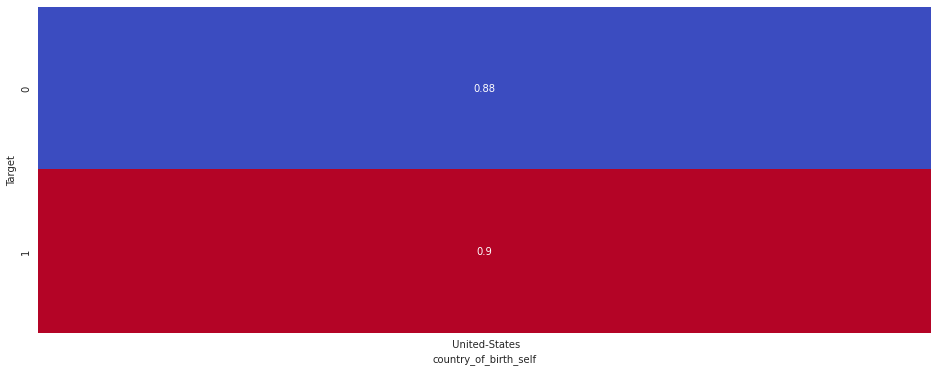

In [39]:
#frequency by which a features appear against target in percentage, for features with more than 5 unique values
# filtering out column with less than 5%
for col in df.select_dtypes(include='object'):
    if df[col].nunique()>5:
        cross_tab = pd.crosstab(df['target'], df[col], normalize='index')
        # Filter out columns based on the sum of their values
        cross_tab = cross_tab.loc[:, cross_tab.sum() >= 0.05]

        sns.set_style("whitegrid")

        plt.figure(figsize=(16, 6))
        sns.heatmap(round(cross_tab,2), annot=True, cmap='coolwarm', fmt='g', cbar=False)
        plt.xlabel(col)
        plt.ylabel("Target")
        plt.show()

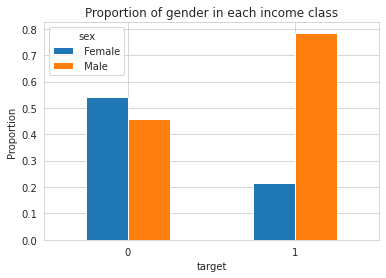

In [46]:
ct = pd.crosstab(df['target'], df['sex'], normalize='index')

barplot = ct.plot.bar(rot=0)


# Add labels and title to the plot
plt.xlabel('target')
plt.ylabel('Proportion')
plt.title('Proportion of gender in each income class')

# Show the plot
plt.show()

# Feature Selection

## Remove Highly Correlated Features

In [26]:
def get_correlated_pairs(df):
    '''Find unique pairs from correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Get the top n absolute correlations in the dataframe'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_correlated_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [27]:
temp_df = df.copy()
# Convert object type columns to categorical type
for col in categorical_cols:
    temp_df[col] = temp_df[col].astype('category')

# Convert categorical type columns to numerical
temp_df = temp_df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

print("Top Correlations")
print(get_top_abs_correlations(temp_df, 20))

Top Correlations
migration_code_change_in_reg        migration_code_move_within_reg             0.998658
                                    year                                       0.970927
migration_code_move_within_reg      year                                       0.970655
detailed_household_and_family_stat  detailed_household_summary_in_household    0.962055
migration_prev_res_in_sunbelt       year                                       0.961040
migration_code_change_in_msa        year                                       0.958922
migration_code_move_within_reg      migration_prev_res_in_sunbelt              0.941492
migration_code_change_in_msa        migration_code_move_within_reg             0.938664
migration_code_change_in_reg        migration_prev_res_in_sunbelt              0.938253
migration_code_change_in_msa        migration_prev_res_in_sunbelt              0.936824
                                    migration_code_change_in_reg               0.933540
country_of_birt

In [28]:
# Removing highly correlated features
remove_cols = ['migration_code_change_in_reg','year','detailed_household_and_family_stat','migration_prev_res_in_sunbelt','migration_code_move_within_reg']
categorical_cols = list(set(categorical_cols) - set(remove_cols))
df.drop(remove_cols, axis=1, inplace=True)
df_test.drop(remove_cols, axis=1, inplace=True)

## Feature Selection using Boruta

In [29]:
def feature_selection(data, target, num_features, cat_features):
    """
    Selects the relevant features using Boruta method.
    """
    
    X = data.drop(target, axis=1)
    y = data[target]

    le = LabelEncoder()
    # Loop over the object columns and label encode each one
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col])
        X[col] = X[col].astype('category')
    
    # Initialize RandomForestClassifier
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    # Initialize BorutaPy feature selector
    feature_selector = BorutaPy(rf, n_estimators=10, verbose=2, random_state=1)

    # Fit the feature selector to the data
    feature_selector.fit(X.values, y.values)

    # Get the relevant features
    relevant_features = set(X.columns[feature_selector.support_])
    
    return relevant_features

In [30]:
relevant_features = feature_selection(df, 'target', continuous_cols, categorical_cols)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	17
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	17
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	17
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	17
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	22
Tentative: 	15
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	22
Tentative: 	15
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	22
Tentative: 	14
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	22
Tentative: 	14
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	22
Tentative: 	14
Rejec

In [31]:
relevant_features

{'age',
 'capital_gains',
 'capital_losses',
 'class_of_work',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'enrolled_in_edu_inst_last_wk',
 'estimated_capital_stock_profit',
 'estimated_income',
 'family_member_under_18',
 'full_or_part_time_employment_stat',
 'hispanic_origin',
 'industry_code',
 'major_industry_code',
 'major_occupation_code',
 'marital_status',
 'num_persons_worked_for_employer',
 'occupation_code',
 'sex',
 'tax_filer_status',
 'veteran_benefits',
 'wage_per_hour',
 'weeks_worked_in_years'}

In [32]:
drop_features = list(set(continuous_cols+categorical_cols)-set(relevant_features))
print("Number of features to be removed",len(drop_features))
print(drop_features)

Number of features to be removed 13
['state_of_previous_residence', 'own_business_or_self_employed', 'member_of_labor_union', 'live_in_this_house_1_year_ago', 'reason_for_unemployment', 'citizenship', 'fill_inc_questionnaire_for_veterans_admin', 'migration_code_change_in_msa', 'country_of_birth_self', 'country_of_birth_mother', 'country_of_birth_father', 'race', 'region_of_previous_residence']


In [33]:
#Dropping irrelevant features
df.drop(drop_features, axis=1, inplace=True)
df_test.drop(drop_features, axis=1, inplace=True)
continuous_cols = list(set(continuous_cols)-set(drop_features))
categorical_cols = list(set(categorical_cols)-set(drop_features))
print("Features left:",len(continuous_cols)+len(categorical_cols))

Features left: 24


#Modeling

In [34]:
target = 'target'

#Converting categorical columns to categories
for col in categorical_cols:
        df[col] = df[col].astype('category')
        df_test[col] = df_test[col].astype('category')

#Train and Validation dataset
X = df.drop(target,axis=1)
y = df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

#Test dataset
X_test = df_test.drop(target,axis=1)
y_test = df_test[target]

In [35]:
def important_features(feature_importances):
    '''Plot feature importances of a model in form of a bar chart'''

    # Create a dataframe from the feature importances
    features = X_train.columns
    importance_df = pd.DataFrame({'features': features, 'importance': feature_importances})

    plt.figure(figsize=(10,8))

    # Plot feature importances using seaborn barplot
    sns.barplot(x='importance', y='features', data=importance_df.sort_values(by='importance', ascending=False))
    plt.xlabel('Feature Importance')
    plt.show()

    print()

    return

## Light GBM Model

In [36]:
def lgbm_model(X_train, y_train, X_val, y_val, params, cat_var):

    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_var)
    lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_var, reference=lgb_train)
    
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val])
    
    return model

In [37]:
#Computing class weights to tackle class imbalances in the training data
cw = class_weight.compute_class_weight('balanced',classes=np.unique(y_train), y=y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'scale_pos_weight': sum(y_test==0)/sum(y_test==1),
    'verbosity': -1
}

In [38]:
#Balanced
bal_lgbm_model = lgbm_model(X_train, y_train, X_val, y_val, params, categorical_cols)

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.192286
[2]	valid_0's binary_logloss: 0.188826
[3]	valid_0's binary_logloss: 0.190286
[4]	valid_0's binary_logloss: 0.194061
[5]	valid_0's binary_logloss: 0.198679
[6]	valid_0's binary_logloss: 0.203492
[7]	valid_0's binary_logloss: 0.208784
[8]	valid_0's binary_logloss: 0.214227
[9]	valid_0's binary_logloss: 0.219443
[10]	valid_0's binary_logloss: 0.224865
[11]	valid_0's binary_logloss: 0.229813
[12]	valid_0's binary_logloss: 0.234848
[13]	valid_0's binary_logloss: 0.239483
[14]	valid_0's binary_logloss: 0.243865
[15]	valid_0's binary_logloss: 0.24793
[16]	valid_0's binary_logloss: 0.251733
[17]	valid_0's binary_logloss: 0.255317
[18]	valid_0's binary_logloss: 0.258711
[19]	valid_0's binary_logloss: 0.261753
[20]	valid_0's binary_logloss: 0.264638
[21]	valid_0's binary_logloss: 0.267374
[22]	valid_0's binary_logloss: 0.26948
[23]	valid_0's binary_logloss: 0.271504
[24]	valid_0's binary_logloss: 0.273235
[25]	valid_0's binary_logloss: 0.274904
[26]	valid_

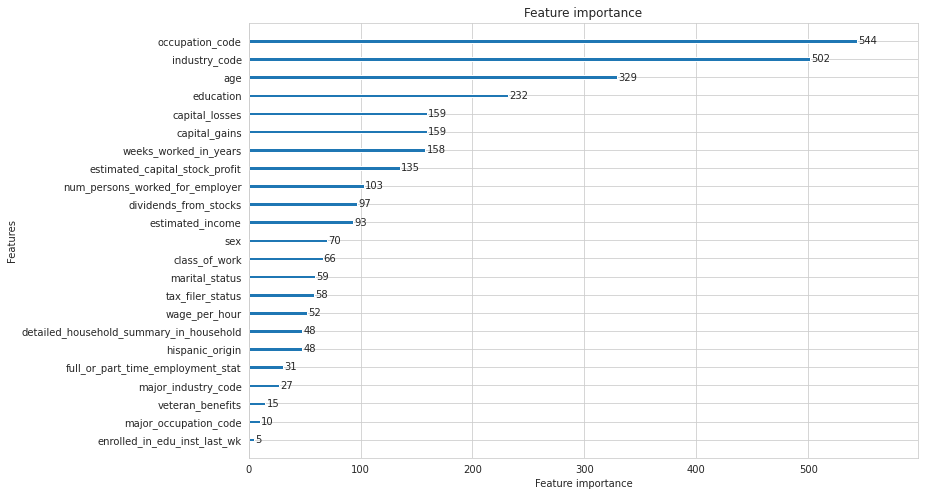

In [39]:
lgb.plot_importance(bal_lgbm_model, figsize=(12, 8))
plt.show()

In [40]:
#Unbalanced
params.pop('scale_pos_weight')
ub_lgbm_model = lgbm_model(X_train, y_train, X_val, y_val, params, categorical_cols)

[1]	valid_0's binary_logloss: 0.20223
[2]	valid_0's binary_logloss: 0.188132
[3]	valid_0's binary_logloss: 0.177301
[4]	valid_0's binary_logloss: 0.169251
[5]	valid_0's binary_logloss: 0.162749
[6]	valid_0's binary_logloss: 0.15738
[7]	valid_0's binary_logloss: 0.15286
[8]	valid_0's binary_logloss: 0.148982
[9]	valid_0's binary_logloss: 0.145786
[10]	valid_0's binary_logloss: 0.142852
[11]	valid_0's binary_logloss: 0.140329
[12]	valid_0's binary_logloss: 0.137948
[13]	valid_0's binary_logloss: 0.135832
[14]	valid_0's binary_logloss: 0.133981
[15]	valid_0's binary_logloss: 0.132298
[16]	valid_0's binary_logloss: 0.130728
[17]	valid_0's binary_logloss: 0.129383
[18]	valid_0's binary_logloss: 0.128202
[19]	valid_0's binary_logloss: 0.126949
[20]	valid_0's binary_logloss: 0.12602
[21]	valid_0's binary_logloss: 0.125145
[22]	valid_0's binary_logloss: 0.124317
[23]	valid_0's binary_logloss: 0.123598
[24]	valid_0's binary_logloss: 0.122752
[25]	valid_0's binary_logloss: 0.122174
[26]	valid_0'

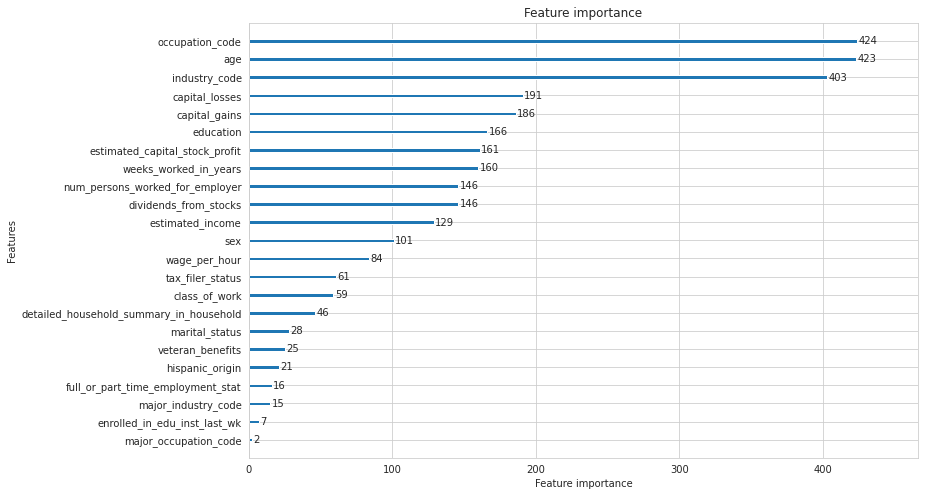

In [41]:
lgb.plot_importance(ub_lgbm_model, figsize=(12, 8))
plt.show()

## CatBoost

In [42]:
def catboost_model(X_train, y_train, X_val, y_val, params, cat_var):

    model = CatBoostClassifier(**params)
    train_pool = Pool(X_train, y_train, cat_features=cat_var)
    val_pool = Pool(X_val, y_val, cat_features=cat_var)

    model.fit(train_pool, eval_set=val_pool)

    pred = model.predict(X_val)

    return model

In [43]:
cw = class_weight.compute_class_weight('balanced',classes=np.unique(y_train), y=y_train)

params = {'loss_function': metrics.Logloss(),
        'eval_metric': metrics.TotalF1(),
         'random_seed': 1,
        'verbose':50,
        'use_best_model': True,
        'class_weights': cw
        }

In [44]:
#Balanced
bal_cb_model = catboost_model(X_train, y_train, X_val, y_val, params, categorical_cols)

Learning rate set to 0.110489
0:	learn: 0.8388914	test: 0.8326451	best: 0.8326451 (0)	total: 759ms	remaining: 12m 38s
50:	learn: 0.8773535	test: 0.8766830	best: 0.8766830 (50)	total: 27.8s	remaining: 8m 37s
100:	learn: 0.8823166	test: 0.8778929	best: 0.8790403 (86)	total: 52s	remaining: 7m 43s
150:	learn: 0.8873750	test: 0.8820674	best: 0.8821902 (149)	total: 1m 17s	remaining: 7m 13s
200:	learn: 0.8904382	test: 0.8811161	best: 0.8826062 (152)	total: 1m 41s	remaining: 6m 44s
250:	learn: 0.8927027	test: 0.8821221	best: 0.8826062 (152)	total: 2m 16s	remaining: 6m 45s
300:	learn: 0.8954810	test: 0.8838484	best: 0.8838484 (300)	total: 2m 41s	remaining: 6m 15s
350:	learn: 0.8968030	test: 0.8836324	best: 0.8841757 (316)	total: 3m 8s	remaining: 5m 49s
400:	learn: 0.8990091	test: 0.8844260	best: 0.8845018 (383)	total: 3m 32s	remaining: 5m 17s
450:	learn: 0.9014302	test: 0.8837075	best: 0.8846031 (405)	total: 3m 59s	remaining: 4m 51s
500:	learn: 0.9038172	test: 0.8836612	best: 0.8846031 (405)	to

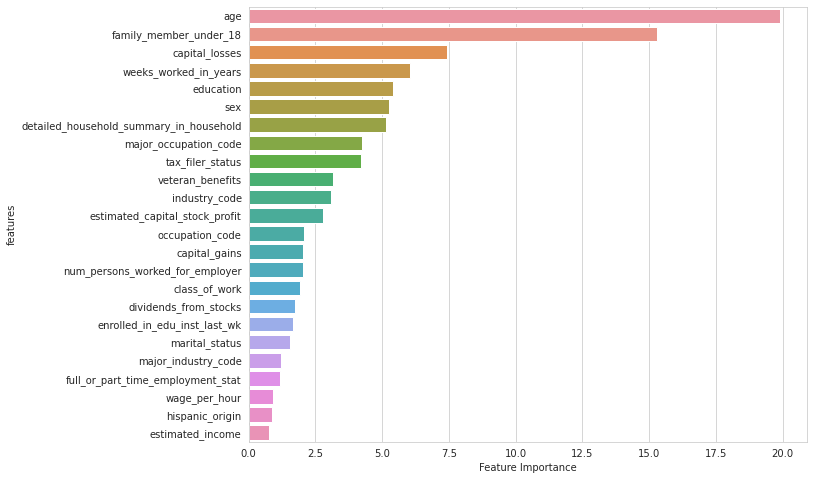

In [45]:
important_features(bal_cb_model.feature_importances_)

In [46]:
#Unbalanced
params.pop('class_weights')
ub_cb_model = catboost_model(X_train, y_train, X_val, y_val, params, categorical_cols)

Learning rate set to 0.110489
0:	learn: 0.9276849	test: 0.9283139	best: 0.9283139 (0)	total: 925ms	remaining: 15m 24s
50:	learn: 0.9488809	test: 0.9483438	best: 0.9483438 (50)	total: 25.2s	remaining: 7m 48s
100:	learn: 0.9520636	test: 0.9507398	best: 0.9508407 (99)	total: 50.5s	remaining: 7m 29s
150:	learn: 0.9535988	test: 0.9513911	best: 0.9514699 (146)	total: 1m 15s	remaining: 7m 6s
200:	learn: 0.9548788	test: 0.9524987	best: 0.9525898 (198)	total: 1m 41s	remaining: 6m 42s
250:	learn: 0.9557646	test: 0.9529721	best: 0.9531856 (239)	total: 2m 6s	remaining: 6m 17s
300:	learn: 0.9564377	test: 0.9532201	best: 0.9533646 (293)	total: 2m 31s	remaining: 5m 50s
350:	learn: 0.9568765	test: 0.9533669	best: 0.9535721 (336)	total: 2m 56s	remaining: 5m 26s
400:	learn: 0.9575660	test: 0.9536544	best: 0.9536544 (400)	total: 3m 22s	remaining: 5m 2s
450:	learn: 0.9579361	test: 0.9532292	best: 0.9536544 (400)	total: 3m 47s	remaining: 4m 36s
500:	learn: 0.9584526	test: 0.9539846	best: 0.9540186 (497)	to

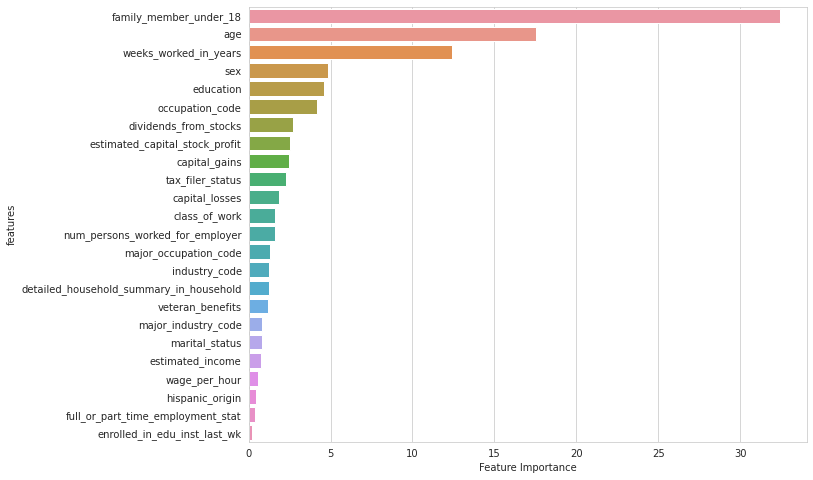

In [47]:
important_features(ub_cb_model.feature_importances_)

# Evaluation

In [48]:
def eval_stats(y, pred):
    '''Print evaluation metrics'''

    print('Accuracy: {:.4}'.format(
        accuracy_score(y, pred)
    ))
    print('F1 score: {:.4}'.format(
        f1_score(y, pred)
    ))
    print('Precision score: {:.4}'.format(
        precision_score(y, pred)
    ))
    print('Recall score: {:.4}'.format(
        recall_score(y, pred)
    ))

def make_confusion_matrix(cf, group_names=None, categories='auto'):
    '''Plots confusion matrix with absolute and percent values'''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=plt.rcParams.get('figure.figsize'))
    sns.heatmap(cf,annot=box_labels,fmt="",cmap='Blues',cbar=True,xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix")

def plot_roc_auc(y, pred_prob):
    '''Plot ROC AUC curve'''

    auc = roc_auc_score(y, pred_prob)
    print("ROC AUC score is:", auc)
    fpr, tpr, thresholds = roc_curve(y, pred_prob)

    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='best')

In [49]:
def eval(y, pred, pred_prob):
    '''Print and plot overall evaluation'''

    make_confusion_matrix(confusion_matrix(y, pred), group_names=['True Neg','False Pos', 'False Neg', 'True Pos'], categories=['<50k','>50k']) 
    plt.show()

    eval_stats(y, pred)

    plot_roc_auc(y, pred_prob)
    plt.show()

    print()

## Results

Baseline (all classified as <50k)


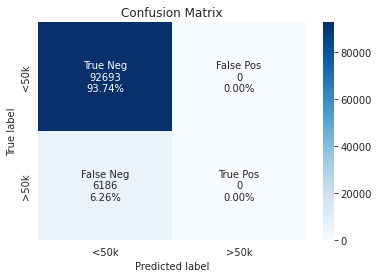

Accuracy: 0.9374
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score is: 0.5


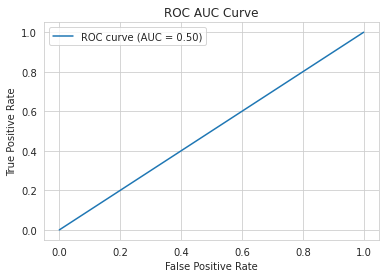

In [50]:
print("Baseline (all classified as <50k)")
pred = len(y_test)*[0]
eval(y_test, pred, pred)

LightGBM Test Evaluation Unbalanced


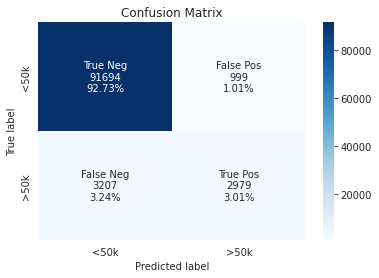

Accuracy: 0.9575
F1 score: 0.5862
Precision score: 0.7489
Recall score: 0.4816
ROC AUC score is: 0.9549081510442666


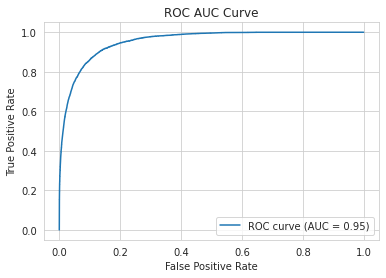

In [51]:
print("LightGBM Test Evaluation Unbalanced")
pred_prob = ub_lgbm_model.predict(X_test)
pred = np.round(pred_prob)
eval(y_test, pred, pred_prob)

LightGBM Test Evaluation balanced


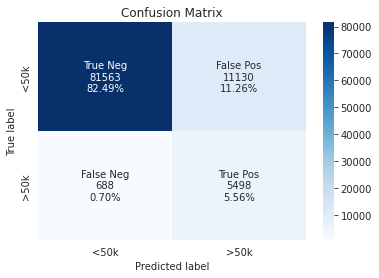

Accuracy: 0.8805
F1 score: 0.482
Precision score: 0.3306
Recall score: 0.8888
ROC AUC score is: 0.9548890081752477


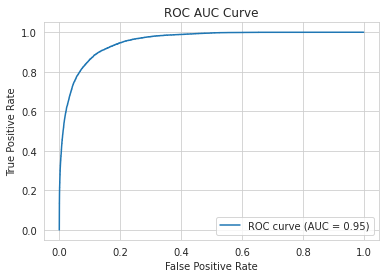

In [52]:
print("LightGBM Test Evaluation balanced")
pred_prob = bal_lgbm_model.predict(X_test)
pred = np.round(pred_prob)
eval(y_test, pred, pred_prob)

CatBoost Test Evaluation unbalanced


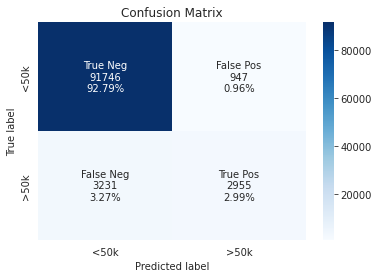

Accuracy: 0.9577
F1 score: 0.5858
Precision score: 0.7573
Recall score: 0.4777
ROC AUC score is: 0.9554537773108869


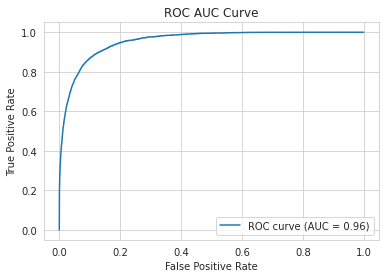

In [56]:
print("CatBoost Test Evaluation unbalanced")
pred = ub_cb_model.predict(X_test)
pred_prob = ub_cb_model.predict_proba(X_test)[:,1]
eval(y_test, pred, pred_prob)

CatBoost Test Evaluation balanced


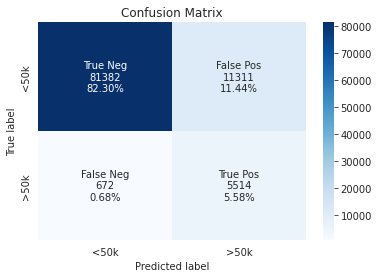

Accuracy: 0.8788
F1 score: 0.4792
Precision score: 0.3277
Recall score: 0.8914
ROC AUC score is: 0.9550204873257361


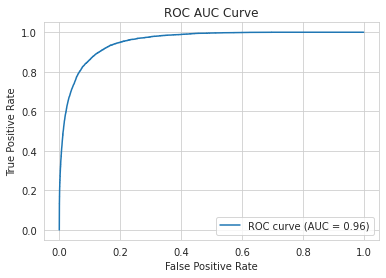

In [57]:
print("CatBoost Test Evaluation balanced")
pred = bal_cb_model.predict(X_test)
pred_prob = bal_cb_model.predict_proba(X_test)[:,1]
eval(y_test, pred, pred_prob)